In [1]:
import json
import matplotlib.pyplot as plt
import os
import torch
from PIL import Image
from torchvision import models, transforms

from fooling_model import FoollingModel
from utils import power_method, process_image

In [2]:
imgs_dir = '../imgs'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

imagenet_transforms = imagenet_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
imgs = []
for imgname in os.listdir(imgs_dir):
    img = Image.open(os.path.join(imgs_dir, imgname)).convert('RGB')
    imgs.append(imagenet_transforms(img).to(device))
img_batch = torch.stack(imgs)

In [4]:
model = models.vgg16(pretrained=True).to(device)
model.eval()

for layer in model.parameters():
    layer.requires_grad = False

fooling_model = FoollingModel(model.features[:6]).to(device)
fooling_model.eval()
matvec, matvec_T = fooling_model.single_get_matvecs(img_batch)

In [5]:
%%time
init = torch.randn(3 * 224 * 224, device=device)
perturb, s = power_method(init, matvec, matvec_T, float('inf'), 10, max_iter=200)

delta tensor(380.2014, device='cuda:0')
delta tensor(294.6795, device='cuda:0')
delta tensor(224.2499, device='cuda:0')
delta tensor(184.2498, device='cuda:0')
delta tensor(151.6839, device='cuda:0')
delta tensor(129.0891, device='cuda:0')
delta tensor(112.2675, device='cuda:0')
delta tensor(99.2371, device='cuda:0')
delta tensor(87.2697, device='cuda:0')
delta tensor(78.5111, device='cuda:0')
delta tensor(71.3022, device='cuda:0')
delta tensor(66.1211, device='cuda:0')
delta tensor(62.0967, device='cuda:0')
delta tensor(55.1362, device='cuda:0')
delta tensor(48.0833, device='cuda:0')
delta tensor(44., device='cuda:0')
delta tensor(40.3980, device='cuda:0')
delta tensor(34.5832, device='cuda:0')
delta tensor(30.9839, device='cuda:0')
delta tensor(26.4575, device='cuda:0')
delta tensor(22., device='cuda:0')
delta tensor(18.6548, device='cuda:0')
delta tensor(16.4924, device='cuda:0')
delta tensor(12.1655, device='cuda:0')
delta tensor(8.9443, device='cuda:0')
delta tensor(10.3923, devic

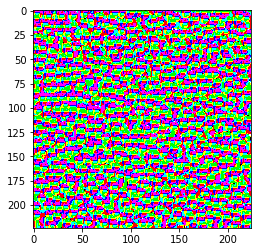

In [6]:
tmp = 0.1 * perturb.view(3, 224, 224).cpu()
plt.imshow(process_image(tmp))

In [7]:
torch.norm(tmp, float('inf'))

tensor(0.1000)

In [8]:
torch.norm(img_batch, float('inf'))

tensor(2.6400, device='cuda:0')

In [9]:
orig_output = model(img_batch).cpu()
#orig_preds = orig_output.argmax(1)
orig_probs, orig_preds = torch.softmax(orig_output, 1).max(1)

In [10]:
orig_probs

tensor([0.9989, 0.9900, 0.5059, 0.9996, 0.6994, 0.8537, 0.9997, 0.9843, 0.9860,
        0.3991, 0.9012, 0.8627, 0.6097, 1.0000, 0.9089, 1.0000, 0.1059, 0.1408,
        0.9572, 0.6492, 0.7720, 0.9704, 0.9192, 0.9928, 0.9971, 0.9048, 0.6775,
        0.7252, 0.4071, 0.9100, 0.9899, 0.6059, 0.1960, 0.9994, 0.6191, 0.8888,
        0.8859, 0.4884, 0.5411, 0.6454, 0.9164, 1.0000, 0.6498, 0.4088, 0.9921,
        0.9993, 0.9339, 0.9254, 0.7355, 0.9885])

In [11]:
orig_preds

tensor([869, 581, 607, 961, 565, 404, 113, 959,  57, 897, 570, 498, 770, 640,
        140, 649, 707, 571, 821, 752, 137, 193, 421, 430, 576, 759, 931, 835,
        972, 472, 560, 826, 471, 388, 762, 854, 959, 305, 656, 560, 483, 565,
        303, 819, 859, 323, 366, 718, 538, 483])

In [12]:
class_index = json.load(open('imagenet_class_index.json'))
idx2name = {
    int(key): value[1]
    for key, value in class_index.items()
}

In [13]:
perturbed_output = model(img_batch + 5 * tmp.to(device)).cpu()
#orig_preds = orig_output.argmax(1)
perturbed_probs, perturbed_preds = torch.softmax(perturbed_output, 1).max(1)

In [14]:
perturbed_probs

tensor([0.3408, 0.3176, 0.4180, 0.2046, 0.2987, 0.1518, 0.0770, 0.5445, 0.2423,
        0.6266, 0.1165, 0.2263, 0.0964, 0.2630, 0.0837, 0.0319, 0.1358, 0.3651,
        0.1148, 0.1543, 0.0897, 0.2359, 0.5478, 0.3077, 0.1144, 0.2199, 0.2595,
        0.6856, 0.1060, 0.1329, 0.2122, 0.2709, 0.2609, 0.1596, 0.7533, 0.5844,
        0.2134, 0.3598, 0.2087, 0.2588, 0.0910, 0.2640, 0.3304, 0.1070, 0.0554,
        0.9032, 0.0339, 0.1356, 0.3869, 0.0806])

In [15]:
perturbed_preds

tensor([869, 581, 685, 611, 741, 646, 539, 109, 330, 796, 796, 530, 636, 892,
        293, 911, 107, 781, 748, 456, 741, 260, 580, 917, 698, 844, 539, 688,
        885, 819, 560, 507, 565, 284, 476, 854, 808, 260, 530, 611, 794, 530,
        311, 688, 674, 323, 151, 845, 712, 203])

In [21]:
(orig_preds != perturbed_preds).float().mean()

tensor(0.9000)

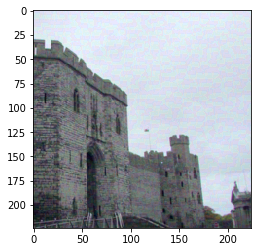

In [17]:
pert = img_batch[-1].cpu() + tmp
plt.imshow(process_image(pert))

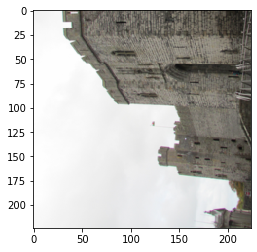

In [40]:
plt.imshow(img_batch[-1])

In [39]:
img_batch[-1].cpu().transpose(0, 2) + 1

tensor([[[242.0000, 242.0000, 242.0000],
         [242.0000, 242.0000, 242.0000],
         [242.0000, 242.0000, 242.0000],
         ...,
         [ 56.0000,  55.0000,  47.0000],
         [ 78.0000,  77.0000,  66.0000],
         [108.0000, 103.0000,  94.0000]],

        [[243.0000, 243.0000, 243.0000],
         [243.0000, 243.0000, 243.0000],
         [243.0000, 243.0000, 243.0000],
         ...,
         [ 58.0000,  61.0000,  52.0000],
         [ 86.0000,  89.0000,  75.0000],
         [ 87.0000,  86.0000,  77.0000]],

        [[243.0000, 243.0000, 243.0000],
         [243.0000, 243.0000, 243.0000],
         [243.0000, 243.0000, 243.0000],
         ...,
         [ 50.0000,  52.0000,  44.0000],
         [ 54.0000,  53.0000,  48.0000],
         [ 73.0000,  73.0000,  68.0000]],

        ...,

        [[249.0000, 249.0000, 249.0000],
         [249.0000, 249.0000, 249.0000],
         [249.0000, 249.0000, 249.0000],
         ...,
         [ 83.0000,  78.0000,  69.0000],
         [ 83.0000,  8

In [86]:
img_batch.mean()

tensor(115.2368, device='cuda:0')

In [5]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1